# Ensemble stacking
Combining models for better generalizing abilities. Will combine the predictions of the best LSTM model and the MLP model. The performance of the two show that they both do generally good, but that one model predicts better at one target than the other. It is therefore assumed that one model manages to extract some information that the other cannot in predicting specific targets. Overall generalizing abilities of the models can most likely be boosted by a technique called "ensemble stacking", where the two models predictions are combined into one final prediction. 

In [1]:
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import keras
from matplotlib import rc 
from tabulate import tabulate

from sklearn.linear_model import LinearRegression

import functions as f
import dl_functions as dlf

Using TensorFlow backend.


In [2]:
# set plot settings
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})
c, palette = f.color_palette()
sns.set_palette(palette)

rc('figure', figsize=(12,6), dpi=200)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
rc('axes', labelsize=14, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')
rc('text', color="#000000")
rc('xtick', color="#000000")
rc('ytick', color="#000000")

SEED=100
np.random.seed(SEED)

In [3]:
# read data and metadata
df_train, df_valid, df_test = f.load_data()
stats, ts, ts_train, ts_valid, ts_test = f.load_metadata()

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats.loc[target_tags,"Std"].values
target_means = stats.loc[target_tags,"Mean"].values

In [4]:
def evaluate_error(mean_preds, std_preds, unc_preds, y_true, target_stds=target_stds):
    """
    Will evaluate the MAE of a set of predictions and targets.
    
    :param preds: Matrix of predictions with shape (n_obs, n_target_variables)
    :param targets: Matrix of true targets with shape (n_obs, n_target_variables)
    :param target_stdevs: 1D vector of the standard deviations of the target variables.
    
    :return return_dict: A dictionary with the computed error variables. 
    """
    maes = f.MAE(y_true, mean_preds, vector=True)
    mses = f.MSE(y_true, mean_preds, vector=True)
    maes_unstd = maes * target_stds
    mses_unstd = mses * target_stds
    
    expected_mean = np.mean(mean_preds, axis=0)
    expected_std = np.mean(std_preds, axis=0)
    expected_unc = np.mean(unc_preds, axis=0)

    # summarize in dataframe
    indexes = ["FT", "TT", "PT"]
    cols = ["MAE (std)", "MSE (std)", "Exp. mean", "Exp. std", "Exp. uncertainty"]
    data = np.column_stack([maes, mses, expected_mean, expected_std, expected_unc])
    df = pd.DataFrame(data, index=indexes, columns=cols)
    df.loc["Avg"] = df.mean()
    
    str_table = tabulate(df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'df': df,
        'str_table': str_table,
        'maes': maes,
        'mses': mses
    }

    return return_dict

In [5]:
def train_lm(lstm_model, mlp_model, x_data, y_data, n_pred=30):
    """
    Trains a linear model to predict targets given predictions of LSTM and MLP model. 
    """
    
    # Make predictions with the LSTM
    lstm_preds = dlf.predict_with_model(lstm_model, x_data, y_data, n_predictions=n_pred)[0]
    
    # Make predictions with the MLP 
    mlp_preds = dlf.predict_with_model(mlp_model, x_data, y_data, n_predictions=n_pred, input_dim=2)[0]
    
    # Concatenate the predictions to one dataset such that it can be read by another model
    X = np.concatenate((lstm_preds, mlp_preds), axis=1)
    
    # Find weights between the predictions of the LSTM model and the MLP by Linear Regression.
    lm = LinearRegression().fit(X,y_data)
    
    return lm
    
    
def evaluate_ensemble(lm, lstm_model, mlp_model, val_tuple, test_tuple, n_pred=30, model_mses=[]):
    
    print("\n **** VALIDATION **** ")
    val_preds, val_unc, val_stds, mses = dlf.predict_with_ensemble(linear_model, lstm_model, mlp_model, 
                                                         val_tuple[0], val_tuple[1], 
                                                         n_pred, 
                                                         return_stds=True, 
                                                         model_mses=model_mses)
    
    val_errs = evaluate_error(val_preds, val_stds, val_unc, val_tuple[1])
    print(val_errs['str_table'])
    
    print("\n **** TEST **** ")
    test_preds, test_unc, test_stds, mses = dlf.predict_with_ensemble(linear_model, lstm_model, mlp_model, 
                                                     test_tuple[0], test_tuple[1], 
                                                     n_pred, return_stds=True, 
                                                     model_mses=model_mses)
    
    test_errs = evaluate_error(test_preds, test_stds, test_unc, test_tuple[1])
    print(test_errs['str_table'])
    
    return val_errs, test_errs

#### Train a linear model
Train a linear model that takes the predictions of the LSTM and MLP as inputs. 
Using the predictions of the models on the validation data for this. 

In [43]:
n_pred=300

# load the LSTM and MLP model
lstm_model = dlf.load_keras_model(ROOT_PATH + "models/lstm_128/50/")
mlp_model = dlf.load_keras_model(ROOT_PATH + "models/mlp_1024/50/")

# train a linear model on validation data
linear_model = train_lm(lstm_model, mlp_model, x_valid, y_valid, n_pred)

#### Evaluating the ensemble

In [92]:
# predict on the validation set
val_preds, val_unc, val_preds_matr = predict_with_ensemble(linear_model, 
                                                           lstm_model, 
                                                           mlp_model, 
                                                           x_valid, 
                                                           y_valid, 
                                                           n_pred,
                                                           return_predictions_matrix=True)

# extract the MSE scores on the validation set. This is the estimated noise in the data. 
model_mses = f.MSE(y_valid, val_preds, vector=True)
print(model_mses)

[0.59412317 0.09753142 0.27452287]


In [93]:
val_eval, test_eval = evaluate_ensemble(linear_model, lstm_model, mlp_model,
                                         (x_valid, y_valid),
                                         (x_test, y_test),
                                         n_pred=n_pred, # optional
                                         model_mses=model_mses # optional
                                         )


 **** VALIDATION **** 
+-----+-------------+-------------+-------------+------------+--------------------+
|     |   MAE (std) |   MSE (std) |   Exp. mean |   Exp. std |   Exp. uncertainty |
|-----+-------------+-------------+-------------+------------+--------------------|
| FT  |     0.58127 |     0.59486 |    -0.24346 |    0.18607 |            0.79482 |
| TT  |     0.25314 |     0.09644 |     1.33649 |    0.14290 |            0.34538 |
| PT  |     0.40381 |     0.27548 |    -0.00353 |    0.17701 |            0.55494 |
| Avg |     0.41274 |     0.32226 |     0.36317 |    0.16866 |            0.56505 |
+-----+-------------+-------------+-------------+------------+--------------------+

 **** TEST **** 
+-----+-------------+-------------+-------------+------------+--------------------+
|     |   MAE (std) |   MSE (std) |   Exp. mean |   Exp. std |   Exp. uncertainty |
|-----+-------------+-------------+-------------+------------+--------------------|
| FT  |     0.51206 |     0.44360 

Make predictions with a model and include uncertainty estimates. 
Total uncertainty is given by: $\eta = \sqrt{(\eta_1^2 + \eta_2^2)}$. $\eta_1$ is the epistemic uncertainty, equivalent to the standard deviance of a sequence of $B$ outputs of the network for a single input point. This is given by $\eta_1 = \text{Std}([\hat y_1, \hat y_2, ..., \hat y_B])$, where $\hat y_i$ is prediction $i$ for an input point. $\eta_2$ is the aleatoric uncertainty, which is the noise in the data. This is given by the MSE on the validation set. 

In [96]:
ensemble_dict = {
    "validation": val_eval,
    "test": test_eval
}

# Error summary
dicts = [ensemble_dict]
columns=["FT", "TT", "PT", "Avg"]
index = ["LSTM/MLP"]
summary, tex = dlf.get_df_from_dicts(dicts, columns, index)
print(summary)
print()

# Uncertainty summary
val_unc_df = val_eval['df'].round(4)
val_unc_df.columns=["MAE", "MSE", "Mean", "Std", 'Uncertainty']

test_unc_df = test_eval['df'].round(4)
test_unc_df.columns=val_unc_df.columns

ensemble_unc = pd.concat([val_unc_df, test_unc_df], axis=1, keys=["Validation", "Test"])
ensemble_unc

         Validation                            Test                        
                 FT      TT      PT     Avg      FT      TT      PT     Avg
LSTM/MLP     0.5813  0.2531  0.4038  0.4127  0.5121  0.2307  0.3867  0.3765



Validation                                        Test                  \
           MAE     MSE    Mean     Std Uncertainty     MAE     MSE    Mean   
FT      0.5813  0.5949 -0.2435  0.1861      0.7948  0.5121  0.4436 -0.3931   
TT      0.2531  0.0964  1.3365  0.1429      0.3454  0.2307  0.0813  1.7781   
PT      0.4038  0.2755 -0.0035  0.1770      0.5549  0.3867  0.2461 -0.0238   
Avg     0.4127  0.3223  0.3632  0.1687      0.5650  0.3765  0.2570  0.4537   

                         
        Std Uncertainty  
FT   0.1971      0.7968  
TT   0.1625      0.3539  
PT   0.1900      0.5587  
Avg  0.1832      0.5698

#### Export results

In [97]:
path = ROOT_PATH + "models/dataframes/"
summary.to_pickle(path + "ensemble_summary_df.pkl")
ensemble_unc.to_pickle(path + "ensemble_uncertainty_df.pkl")

In [99]:
f.save_pickle(linear_model, ROOT_PATH + "models/ensemble/linear_model.pkl")
lstm_model.save(ROOT_PATH + "models/ensemble/lstm_model.h5")
mlp_model.save(ROOT_PATH + "models/ensemble/mlp_model.h5")

### Example

In [4]:
# load models
lstm = keras.models.load_model(ROOT_PATH + "models/ensemble/lstm_model.h5")
mlp = keras.models.load_model(ROOT_PATH + "models/ensemble/mlp_model.h5")
lm = f.load_pickle(ROOT_PATH + "models/ensemble/linear_model.pkl")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [ ]:
n_pred = 300
mean_preds, unc_preds, pred_matr = dlf.predict_with_ensemble(lm, lstm, mlp, 
                                                             x_test, y_test, 
                                                             n_pred=n_pred, 
                                                             return_predictions_matrix=True)

In [ ]:
from scipy.stats import norm
signal = 0
run = 0

mean_pred = mean_preds[run,signal]
unc_pred = unc_preds[run,signal]
preds = pred_matr[run,:,signal]

fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(preds, ax=ax, fit=norm, kde=False,
             fit_kws={"lw":3, 
                      "color":c["blue_dark"], 
                      "label":r'$ \sim {0}(\mu={1}, \sigma^2={2})$'.format("\mathcal{N}", 
                                                                round(mean_pred,2), 
                                                                round(unc_pred**2,2))},
            #hist_kws={"alpha": 1}
            )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=False)
ax.set_xlim((mean_pred-3,mean_pred+3))

for label in ax.get_yticklabels()[::2]:
    label.set_visible(False)
    
for label in ax.get_xticklabels()[::2]:
    label.set_visible(False)


fig.show()

In [ ]:
from scipy.stats import shapiro
shapiro(preds)

In [15]:
def plot_pred_matrix(preds_matr, preds_uncertainties, y_data, time_vec, target_tags, 
                              start_idx=12000, n_obs=200, plotCI=False, z=1.645):
        
    n_targets = y_data.shape[-1]
    n_iterations = preds_matr.shape[0]
    
    mean_preds = np.array([np.mean(preds_matr[:,:,i], axis=0) for i in range(n_targets)]).T
    std_preds = preds_uncertainties
    
    start_idx = start_idx if start_idx < len(y_data) else max(0,len(y_data)-n_obs) 
    end_idx = min(len(y_data),start_idx+n_obs)
    interval = range(start_idx,end_idx)
    
    time = time_vec[interval]
    
    for signal in range(n_targets):
        
        fig, ax = plt.subplots(1,1,figsize=(12,4), dpi=200)
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))
        
        if not plotCI: # then plot individual predictions 
            #for run in range(n_iterations):
            for run in range(min(80,n_iterations)):
                preds = preds_matr[run, interval, signal]
                ax.plot(time, preds, alpha=0.25, color="gray", markersize=0, linestyle="-")
        else: 
            # calculate upper and lower bounds
            CI_low = np.subtract(mean_preds,std_preds*z)
            CI_high = np.add(mean_preds,std_preds*z)
            
            # plot it
            ax.fill_between(time,
                             CI_low[interval,signal], 
                             CI_high[interval,signal], 
                             color="gray", alpha=0.3, label="CI (z={0})".format(z))
            
            ax.plot(time,CI_low[interval,signal], c="darkgray")
            ax.plot(time,CI_high[interval,signal], c="darkgray")
        
        ax.plot(time, mean_preds[interval, signal], c=c["red"], lw=2, ls="-", ms=0, 
                 label="Mean prediction")
        ax.plot(time, y_data[interval, signal], c=c["blue_med"], lw=2, ls="-", ms=0, 
                 label="Actual")
        #plt.ylabel(target_tags[signal])
        #plt.legend(frameon=True, loc="upper right")
        #ax.legend(frameon=True)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=True, ncol=5, frameon=False)
        
        fig.show()

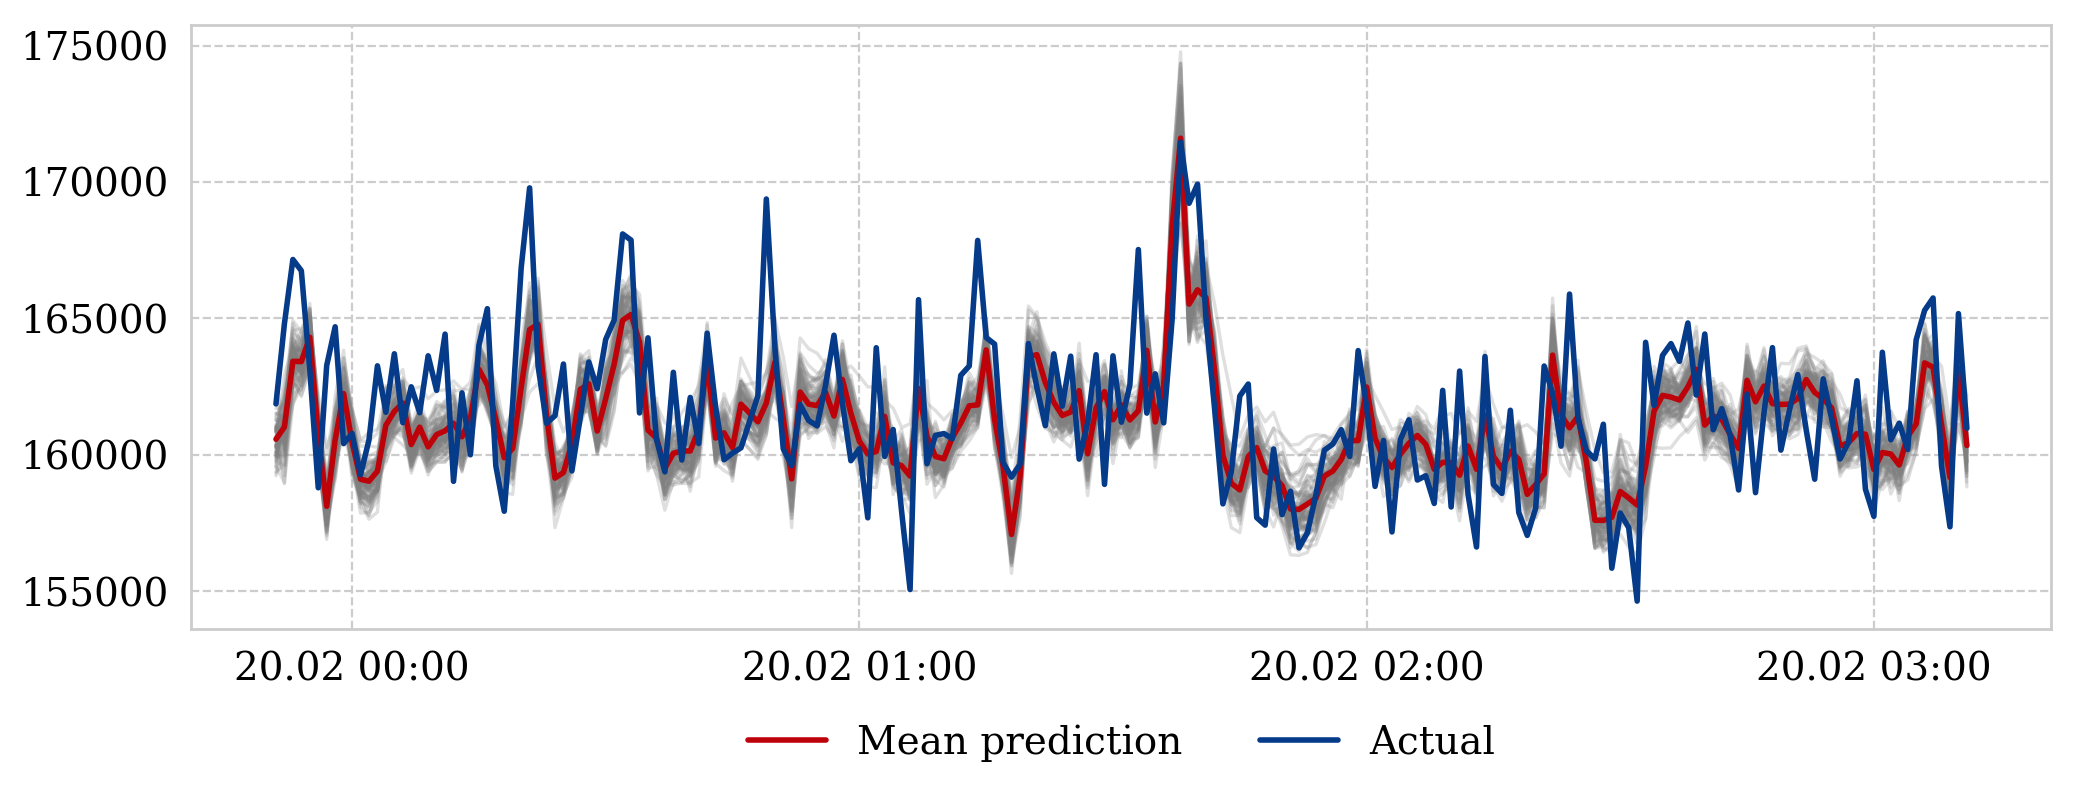

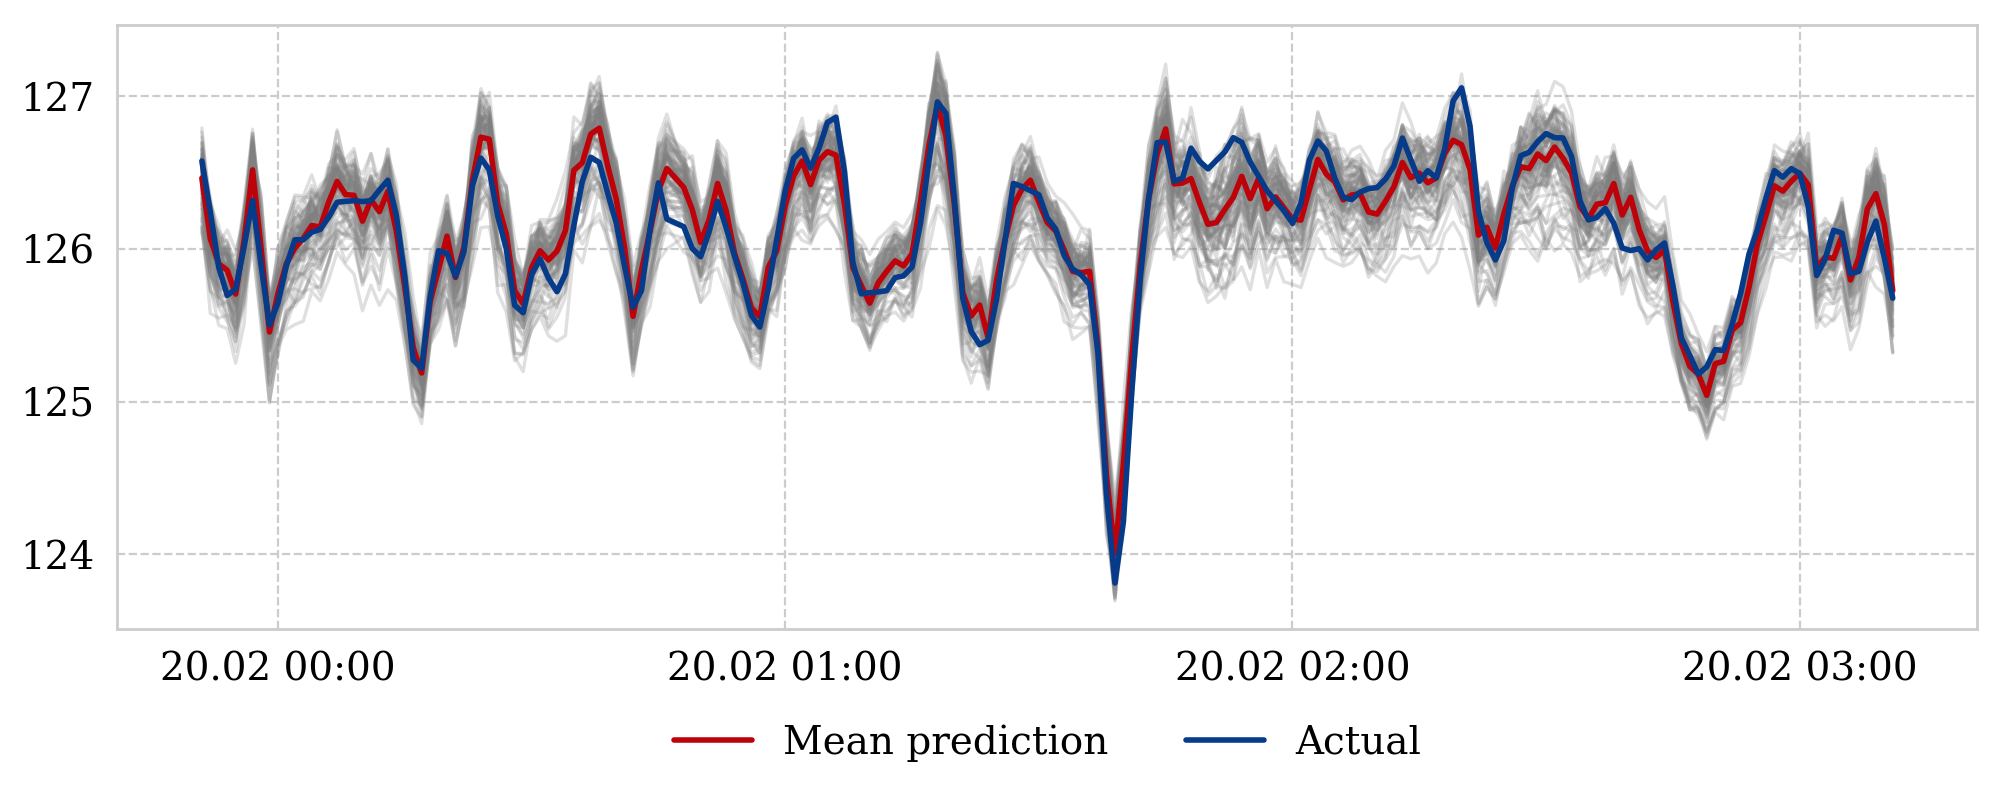

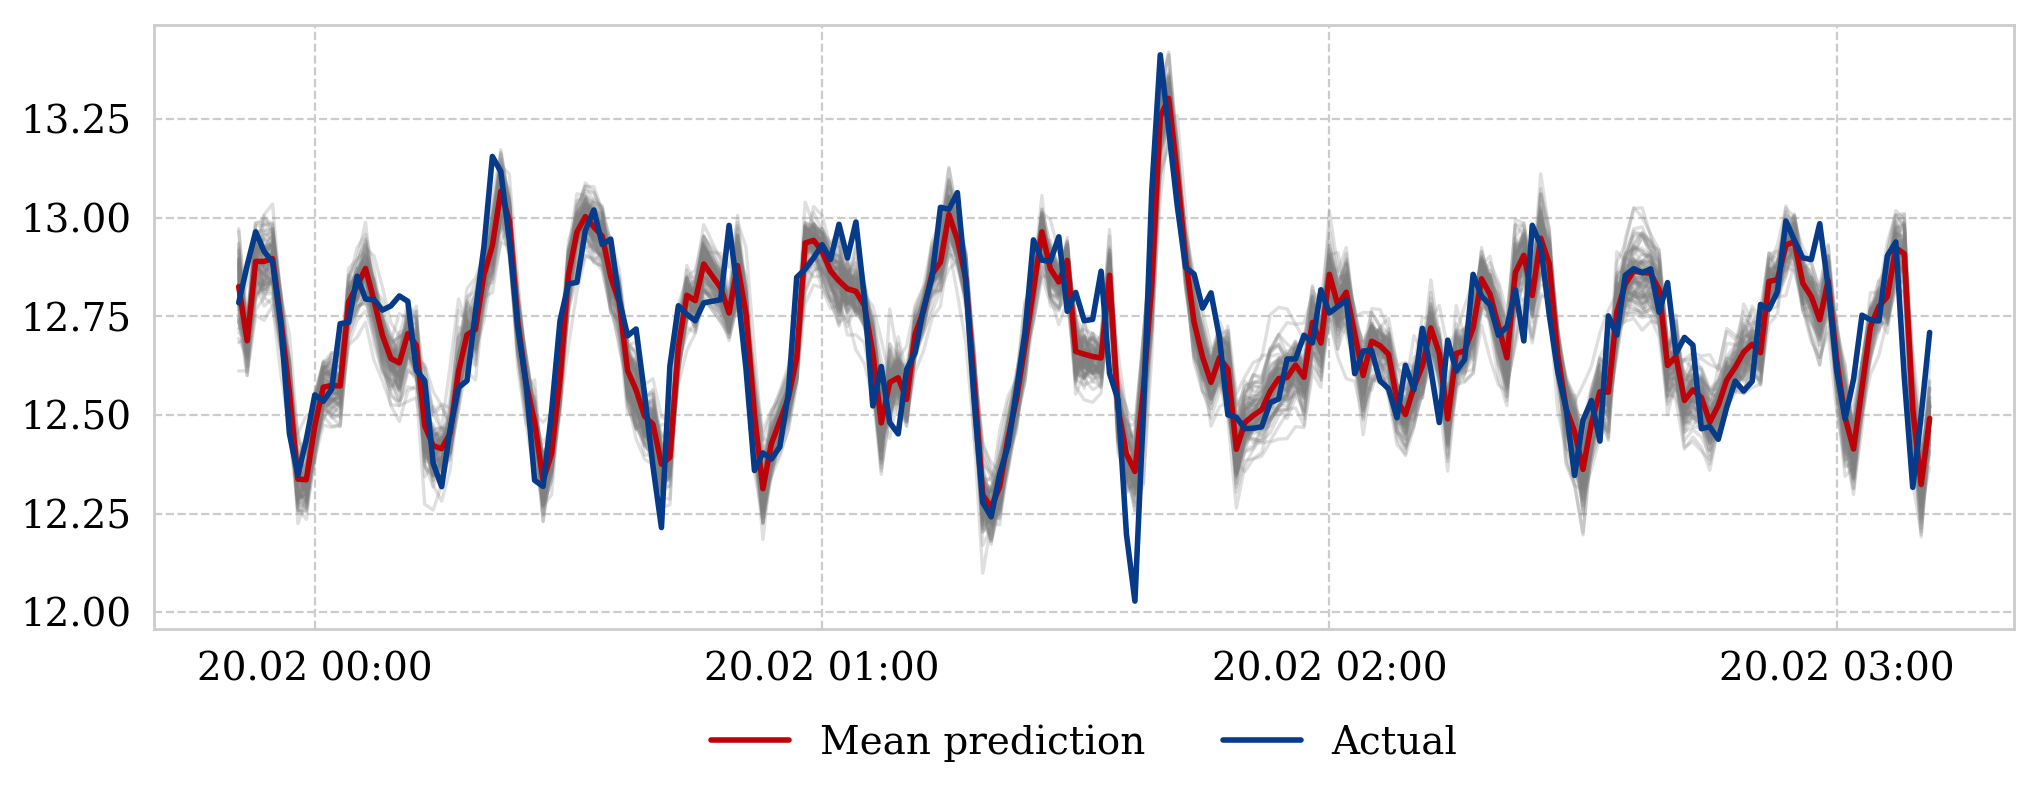

In [16]:
plot_pred_matrix(pred_matr*target_stds+target_means, 
                 unc_preds*target_stds, 
                 y_test*target_stds+target_means, 
                 ts_test, 
                 ["Discharge flow", "Discharge temperature", "Discharge pressure"],
                 start_idx=11970, n_obs=200, plotCI=False, z=3.1)